# A small introduction into the nearest neighbor based information theoretical measures introduced in nn_info

In [1]:
# load packages
import numpy as np
import pandas as pd
import nn_info as nit
from scipy.stats import uniform, multivariate_normal as mv
from scipy.stats import differential_entropy as entropy
import matplotlib.pyplot as plt
import seaborn as sns

# <font color='red'> nit.info </font>

### <font color='red'> nit.info(*measure*, approach=*'nn_ratio'*, k=*3*, unit=*'bits'*, prior=*'empiric'*, epsilon=*False*) </font>

+ ### <font color='brown'> *measure* in *['MI', 'KLD', 'entropy']* </font>
#### <font color='brown'>defines which information theoretical measure to compute. MI = mutual information, KLD = Kullback-Leibler divergence </font>
+ ### <font color='brown'>approach in *['nn_ratio', 'nn_distance']* </font>
#### <font color='brown'>there are two variants in how nearest neighbors can be applied for density(-ratio) estimation. A combination of *measure* and approach defines the estimator. Note: There is no ratio approach for entropy estimation
+ ### <font color='brown'>k has to be a positive integer </font>
#### <font color='brown'> defines the index-numer of neighbors to be used for approximation </font>
+ ### <font color='brown'> unit in *['bits', 'nats']* </font>
#### <font color='brown'> for unit=bits log_2 is applied, for unit=nats, the natural logarithm is applied </font>
+ ### <font color='brown'> prior is either 'empiric' or a real number above or equal 1 </font>
#### <font color='brown'> Only relevant for ratio approach: defines parameters for the prior Beta-distribution. If prior='empiric', hyperparameters are derived with respect to the data. Otherwise, value of prior sets both hyperparameters. </font>
+ ### <font color='brown'> epsilon is logical </font>
#### <font color='brown'> only relevant for distance approach for KLD estimation: If data consists of several doublets (e.g. in case of 0-inflated data), epsilon must be set to True. </font>

## 0. differential entropy
### $$H(p):=-\int\ln(p(x))p(x)dx$$
$$\text{  with  }X_i \sim P, \text{   } X_i,X_j \text{    iid and   } X=\{X_i\}_{i=1}^n \text{  a nearest neighbor estimator is}$$
## <font color='red'> nit.info('entropy', approach='nn_distance').estimator($X$) </font>
### $$\hat H_n(X):=\frac{1}{n}\sum_{i=1}^n\ln(r_{1,i}^d(n-1)c_{1,d}e^{\gamma})$$
$$\text{with    }r_{1,i} \text{  is the nearest neighbor of } X_i \text{   in the sample   }$$
$$d \text{  is the dimensionality of the data}$$
$$c_{1,d} \text{  is the volume of the }d\text{  dimensional unit ball and }$$
$$\gamma \text{  is the Euler-Mascheroni constant}$$


#### as the variance, entropy is a measure for dispersion. but while variance measures the average distance to the mean, entropy measures the uncertainty given a probability density. The difference of the approaches becomes evident in multimodal distributions: 

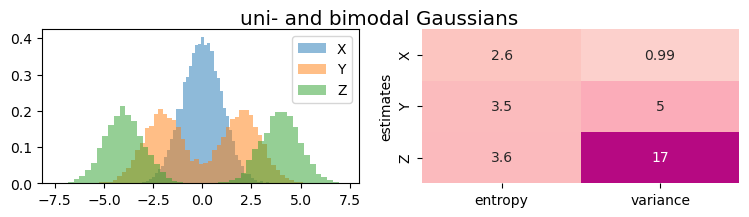

In [2]:
# for the entropy it does not matter how distant the modes are, but that there is uncertainty which mode to choose
n = 10000
var = 1

X = mv(0,var).rvs(n)

Y1 = mv(-2,var).rvs(int(0.5*n))
Y2 = mv(2,var).rvs(int(0.5*n))
Y = np.concatenate([Y1,Y2])

Z1 = mv(-4,var).rvs(int(0.5*n))
Z2 = mv(4,var).rvs(int(0.5*n))
Z = np.concatenate([Z1,Z2])

L = [X,Y,Z]
L_names = ['X','Y','Z']

uncert = np.array([(nit.info('entropy', approach='nn_distance').estimator(X), np.var(X)),
                  (nit.info('entropy', approach='nn_distance').estimator(Y), np.var(Y)),
                  (nit.info('entropy', approach='nn_distance').estimator(Z), np.var(Z))])
UC = pd.DataFrame(uncert, index=['X','Y','Z'], columns=['entropy', 'variance'])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,2))
fig.suptitle('uni- and bimodal Gaussians', fontsize='x-large')
for i in range(3):
    ax1.hist(L[i], density = True, bins=50, label = L_names[i], alpha=0.5)
ax1.legend()
sns.heatmap(UC, ax=ax2, annot=True, vmin=-5, vmax=25, cmap='RdPu', cbar=False)
ax2.set_ylabel('estimates')
plt.show()

#### in a multivariate setting, entropy can be used to measure dispersion. Something like a multivariate variance does not exist

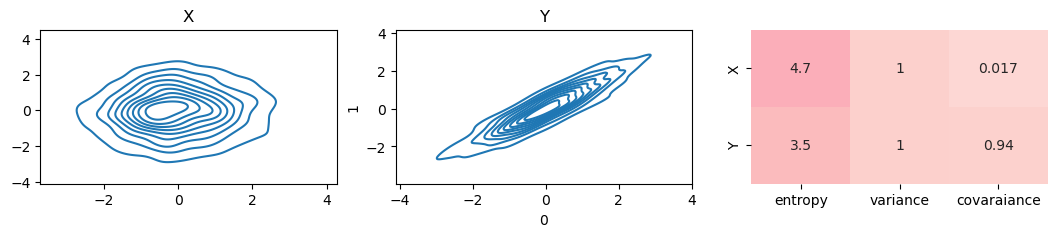

In [3]:
# example on 2D Gaussians
n = 1000
X = pd.DataFrame(mv([0,0], np.array([[1,0],[0,1]])).rvs(n))
Y = pd.DataFrame(mv([0,0], np.array([[1,0.9],[0.9,1]])).rvs(n))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (13,2))
sns.kdeplot(data = X, x = X.iloc[:,0], y = X.iloc[:,1],  ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax1.set_title('X')
ax2.set_title('Y')
sns.kdeplot(data = Y, x = Y.iloc[:,0], y = Y.iloc[:,1],  ax=ax2)
uncert = np.array([(nit.info('entropy', approach='nn_distance').estimator(X), 
                    np.var(X, axis=0)[0], np.cov(X.iloc[:,0],X.iloc[:,1])[0,1]),
                   (nit.info('entropy', approach='nn_distance').estimator(Y), 
                    np.var(Y, axis=0)[0], np.cov(Y.iloc[:,0],Y.iloc[:,1])[0,1])])
UC = pd.DataFrame(uncert, index = ['X','Y'], columns = ['entropy', 'variance', 'covaraiance'])
sns.heatmap(UC, cbar = False,ax = ax3, annot = True, vmin=-5, vmax=25, cmap='RdPu')
plt.show()

## 1 Kullback-Leibler divergence:
### $$D(p,q)=\int\ln(\frac{p(x)}{q(x)})p(x)dx$$
$$\text{  with  }X_i \sim P, \text{   and  }Y_i \sim Q\text{   and further  } X_i,X_j,Y_i,Y_j  \text{    iid and   } X=\{X_i\}_{i=1}^n, Y=\{Y_i\}_{i=1}^n \text{  nearest neighbor estimators are}$$
## <font color='red'> nit.info('KLD').estimator($(X,Y)$) </font>
### $$\hat D_{k,n}^B(X,Y):=\frac{1}{n}\sum_{i=1}^n\ln\left(\frac{N_{i,k} + \hat\alpha}{k-N_{i,k} + \hat\beta}\right)$$
$$\text{with  } N_{i,k} \text{   the number of neighbors in  }X \text{   of  } X_i \text{   in the  }k\text{-neighborhood  of the joint sample  }X\cup Y$$
$$\text{and }   \hat{\alpha} \text{  and  } \hat \beta \text{   hyperparameters of the prior Beta-distribution}$$ 

## <font color='red'> nit.info('KLD', approach='nn_distance).estimator($(X,Y)$) </font>
### $$\hat D_{k,n}^W(X,Y):=\frac{d}{n} \sum_{i=1}^n \ln \left(\frac{r^x_{i,k}}{r^y_{i,k}}\right) + \ln\left(\frac{n-1}{n}\right)$$
$$\text{with  }r^x_{i,k}, r^y_{i,k}\text{   the distance from  }X_i \text{  to the }k\text{th neighbor in }X \text{ or }Y \text{, respectively}$$ 

#### KLD measures the dissimilarity between (multivariate) distributions. This kind of multivariate investigation is not feasible via testing (e.g.) ttests. Further, KLD takes into account the whole probability densities, instead of just their mean values. However, so far KLD values provide dissimilarities on a continuous scale and do not provide a binary test result. 

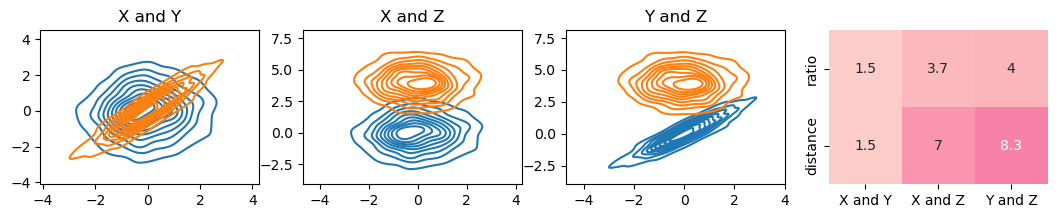

In [4]:
# measure dissimilarity between 2D Gaussians
Z = pd.DataFrame(mv([0,4], np.array([[1,0],[0,1]])).rvs(n))
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(13,2))
sns.kdeplot(data = X, x = X.iloc[:,0], y = X.iloc[:,1],  ax=ax1)
sns.kdeplot(data = Y, x = Y.iloc[:,0], y = Y.iloc[:,1],  ax=ax1)

sns.kdeplot(data = X, x = X.iloc[:,0], y = X.iloc[:,1],  ax=ax2)
sns.kdeplot(data = Z, x = Z.iloc[:,0], y = Z.iloc[:,1],  ax=ax2)

sns.kdeplot(data = Y, x = Y.iloc[:,0], y = Y.iloc[:,1],  ax=ax3)
sns.kdeplot(data = Z, x = Z.iloc[:,0], y = Z.iloc[:,1],  ax=ax3)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax3.set_xlabel('')
ax3.set_ylabel('')
ax1.set_title('X and Y')
ax2.set_title('X and Z')
ax3.set_title('Y and Z')

uncert = np.array([(nit.info('KLD').estimator((X,Y)),
                   nit.info('KLD').estimator((X,Z)),
                   nit.info('KLD').estimator((Y,Z))),
                   (nit.info('KLD', approach='nn_distance').estimator((X,Y)),
                   nit.info('KLD', approach='nn_distance').estimator((X,Z)),
                   nit.info('KLD', approach='nn_distance').estimator((Y,Z)))])
UC = pd.DataFrame(uncert, index=['ratio', 'distance'], columns=['X and Y', 'X and Z', 'Y and Z'])
sns.heatmap(UC, annot=True, cbar=False, ax = ax4, vmin=-5, vmax=25, cmap='RdPu')
plt.show()

## 2 Mutual information
### $$I(p_1,p_2):=\int \ln\left(\frac{p(x)}{p_1(x_1)p_2(x_2)}\right)p(x)dx $$
$$\text{where  }p_1,p_2 \text{  are marginal probability densities of  } p $$
$$ \text{  as can be seen, MI is a special application of the KLD with  }q(x)=p_1(x_1)p_2(x_2)$$
$$ \text{therefore, given a sample }X:=(X^1,X^2), \text{  estimators for the dependency between  }X^1 \text{  and  } X^2 \text{  are} $$
## <font color='red'> nit.info('MI').estimator($(X^1,X^2)$) </font>
$$ \text{  as application of the algorithm, this is equivalent to nit.info('KLD').estimtor($(X,\tilde Y)$)}$$
$$ \text{with  }\tilde Y=(X^1,\tilde X^2)\text{  where  }\tilde X^2 \text{  consists of randomly shuffled elements of  }X^2 $$
## <font color='red'> nit.info('MI', approach='nn_distance').estimator($(X^1,X^2)$) </font>
### $$ \hat I_{n,k}(X^1,X^2):= \psi(n)-\psi(k) - \frac{1}{n} \sum_{i=1}^n\left(\psi(k^1_i) + \psi(k^2_i)\right) $$
$$ \text{where  }\psi\text{  is the digamma function  and  }k^1_i,k^2_i \text{  are the number of neighbors towards  }X_i \text{  in the marginal spaces of  }X^1, X^2 \text{  respectively. Here, the marginal  }k\text{'s  are the number of elements that are inside of the}$$
$$ ||\cdot||^{\infty} \text{-ball around  }X_i \text{  spanned by the  }k\text{'s neighbor in the complete space.}$$

#### MI is a measure for dependency. Heuristically speaking, it can be seen as a 'fancy' version of correlation with no false positives (such as - a correlation can be 0 despite the dependency of two random variables) Further, MI can be applied on multivariate random varaibles, such that a combinatorial dependency becomes measurable

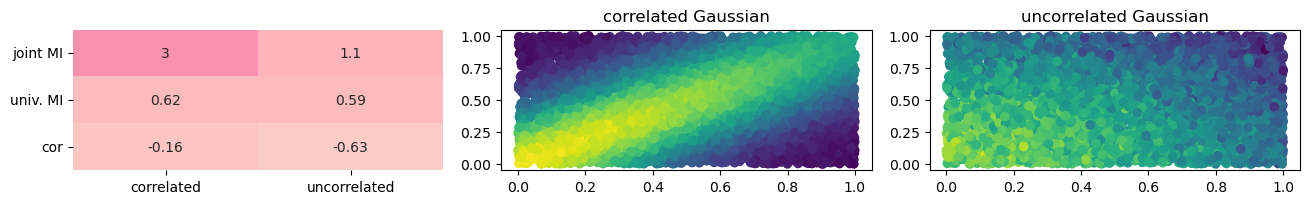

In [5]:
# create 3D example where X^1 are 2D uniforms and X^2 is a Gaussian pdf with X^1 as domain
cor = []
uncor = []
for i in range(50):
    # 2D uniform
    x = uniform.rvs(size = (5000,2)) 
    
    #evaluation pdfs of 2D gaussians on uniform sample 
    z = np.random.normal(mv([0,0],[[1,0.95],[0.95,1]]).pdf(x),0.01)
    z_star = np.random.normal(mv([0,0],[[1,0],[0,1]]).pdf(x),0.01)


    cor.append([nit.info('MI').estimator((x,z)),
                nit.info('MI').estimator((x[:,0],z)), 
                np.corrcoef((x[:,0],z))[0,1]])
                
    uncor.append([nit.info('MI').estimator((x,z_star)),
                  nit.info('MI').estimator((x[:,0],z_star)), 
                  np.corrcoef((x[:,0],z_star))[0,1]])


ind = ['joint MI', 'univ. MI', 'cor'] 
Cor = pd.DataFrame(cor, columns = ind)
Uncor = pd.DataFrame(uncor, columns = ind)

# show different measures to capture dependency between x- and y-axis and color scheme
C = pd.concat([Cor.mean(axis= 0), Uncor.mean(axis= 0)], axis = 1)
C.columns= ['correlated', 'uncorrelated']
# make plot 
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(13,2))
fig.tight_layout()
ax3.scatter(x[:,0], x[:,1], c = z_star)
ax3.set_title('uncorrelated Gaussian')
ax2.scatter(x[:,0], x[:,1], c = z)
ax2.set_title('correlated Gaussian')
sns.heatmap(C, annot=True, cbar=False, ax = ax1, vmin=-5, vmax=15, cmap='RdPu')
plt.show()